# **Deep Fashion Attribute Prediction**

**This is a multi-label, multi-class classification problem.**

## Major Steps

1. **Environment Setup and Downloading Dataset:**
     - Downloading and extracting data
     - Importing necessary files
2. **Exploratory Data Analysis:**
     - Data Inspection
       - Load and inspect csv file
       - Load and inspect images
     - Data Cleaning
      - Removing non-image files
      - Removing duplicates from labels
      - Understanding classes
     - Univariate Analysis
      - Count Plots and Percentage division
      - Handling Missing Values: kNN Imputation

3. **Data Preprocessing Pipeline:**
    - Resize Images
    - Normalize Images

3. **Define and Compile the Model:**
4. **Train the Model:**
5. **Inference Script:**
6. **Documentation:** Ensure your ReadMe file is comprehensive and clear.

**Extra Work:** \
Deployment - Docker, Streamlit \
Generative AI application \
Fashion GPT \



# Environment Setup and Downloading Dataset

In [1]:
%%capture
# download the dataset zip file
!gdown --id 1p7-dU6rDuqZ2mxv5ac5AWndt4z19aS6j

# extract the zip file
!unzip ./classification-assignment.zip;
!rm -rf ./__MACOSX;

In [2]:
# import statements
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import seaborn as sns
import numpy as np

# Exploratory Data Analysis

## 1. Dataset Inspection


### Read the ground truth labels

In [3]:
# load attributes.csv file
path_csv = './classification-assignment/attributes.csv'
attributes_df = pd.read_csv(path_csv)
original_attributes = attributes_df.copy()
attributes_df.head()

,filename,neck,sleeve_length,pattern
0,cdc8cd2a-0938-4970-a3b5-f5ed9595222c1527925869...,6.0,NaN,4.0
1,11469770662809-Metersbonwe-Navy-T-shirt-485146...,5.0,3.0,9.0
2,11479107741104-Tommy-Hilfiger-Men-Navy-Blue-St...,6.0,1.0,9.0
3,f7ad67ab-eeb1-4449-8f63-7b580d2797e71532342804...,NaN,0.0,9.0
4,11516770810185-Splash-Men-Tshirts-767151677081...,6.0,3.0,9.0


In [4]:
print(f"Shape of the attributes_df: {attributes_df.shape} \n")

print(attributes_df.info())

Shape of the attributes_df: (2238, 4) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2238 entries, 0 to 2237
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   filename       2238 non-null   object 
 1   neck           1783 non-null   float64
 2   sleeve_length  1786 non-null   float64
 3   pattern        1791 non-null   float64
dtypes: float64(3), object(1)
memory usage: 70.1+ KB
None


There are total 2238 entries in the `attributes.csv` file. This means there are more entries than images.

Each attribute column has null values.

In [5]:
attributes_df.describe()

,neck,sleeve_length,pattern
count,1783.000000,1786.000000,1791.000000
mean,4.487942,2.543673,8.132887
std,2.069430,0.915810,2.108823
min,0.000000,0.000000,0.000000
25%,3.000000,3.000000,9.000000
50%,6.000000,3.000000,9.000000
75%,6.000000,3.000000,9.000000
max,6.000000,3.000000,9.000000



### Read the images

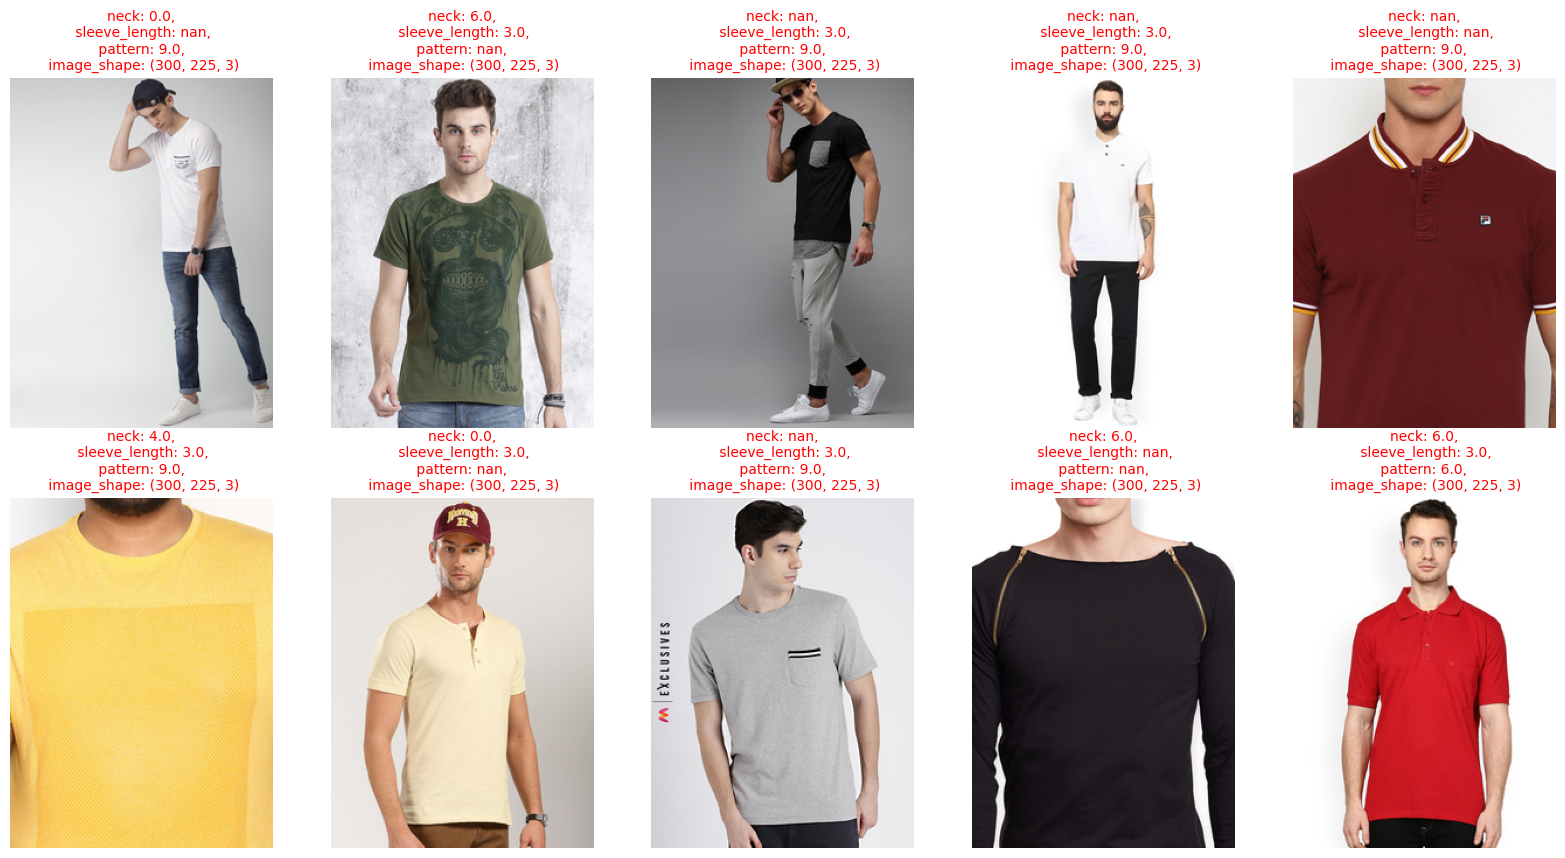

In [6]:
# Function to get attribute values for a given file name
def get_attributes(df, file_name):
    attribute_cols = ['neck', 'sleeve_length', 'pattern']
    attributes = df[df['filename'] == file_name][attribute_cols].values[0]
    return attributes


def display_10_random_images(file_names, image_directory):
    # Select 10 random images
    random_images = random.sample(file_names, 10)

    # Create a figure with 1 row and required columns
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))

    # Load and display each image
    for i, image_file in enumerate(random_images):
        img = plt.imread(os.path.join(image_directory, image_file))
        ax = axes[i // 5, i % 5]
        ax.imshow(img)
        ax.axis('off')

        # Write the attributes at the bottom of the image
        attributes = get_attributes(attributes_df, image_file)
        display_str = f"neck: {attributes[0]},\n sleeve_length: {attributes[1]},\n pattern: {attributes[2]}, \n image_shape: {img.shape}"
        axes[i // 5, i % 5].set_title(display_str, fontsize=10, color='red')

    plt.show()


# List of all image file names in the directory
image_directory = "./classification-assignment/images"
file_names = os.listdir(image_directory)
display_10_random_images(file_names, image_directory)

In [7]:
print("Number of files in image directory:", len(file_names))

# extracting extensions to analyse types of files in directory
extensions = [name.split(".")[-1] for name in file_names]
extensions_count = pd.Series(extensions).value_counts()
print("Extensions:", extensions_count)

Number of files in image directory: 1783
Extensions: jpg    1782
db        1
Name: count, dtype: int64


We only have 1782 images in the directory. We need to remove the files with invalid extensions.

## 2. Data Cleaning

### Removing files with wrong extension and duplicates

In [8]:
# Removing wrong extensions
# selecting only image files from images directory
image_file_names = [name for name in file_names if name.endswith("jpg")]
print(f"Number of valid image files: {len(image_file_names)}")

# Removing duplicate file names
# checking for duplicates, and optimizing for membership testing
image_set = set(image_file_names)
print(f"Number of valid image files without duplicates: {len(image_set)}")

Number of valid image files: 1782
Number of valid image files without duplicates: 1782


### Removing duplicates from labels

There are 2238 entries in the attributes.csv file but only 1782 images. So we need to remove excess entries.

In [9]:
# keep only the rows with corresponsing image in directory
attributes_df = attributes_df[attributes_df['filename'].isin(image_set)]
attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1797 entries, 0 to 2237
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   filename       1797 non-null   object 
 1   neck           1425 non-null   float64
 2   sleeve_length  1432 non-null   float64
 3   pattern        1438 non-null   float64
dtypes: float64(3), object(1)
memory usage: 70.2+ KB


In [10]:
# check for duplicate rows in attributes_df
duplicate_rows = attributes_df[attributes_df.duplicated()]
print("Number of duplicate rows:", len(duplicate_rows))

# check for duplicate filenames in attributes_df
duplicate_filenames = attributes_df['filename'].duplicated()
print(f"Number of duplicate filenames: {duplicate_filenames.sum()}")

Number of duplicate rows: 1
Number of duplicate filenames: 15


This means that there are 15 rows with duplicate filenames but different attribute values.
Out of these 15 duplicates only 1 entry has the same filename and attribute values.

In [11]:
# check for file names of duplicates
list(attributes_df['filename'][duplicate_filenames])

['11519985443093-na-6291519985442963-1.jpg',
 '3d2204b9-8db8-41bc-9e6e-7dcbd0e5bfd81527921368221-Roadster-Men-Beige-Printed-Round-Neck-T-shirt-51915279213668-2.jpg',
 '184ee860-cb0c-43e9-a59f-b087d9517e971535628417104-MESH-HOODED-VEST-2301535628416957-4.jpg',
 '11500972213413-HERENOW-Men-Navy-Blue-Solid-Henley-Neck-T-shirt-1741500972213293-2.jpg',
 'f617edb8-a874-453b-b6d3-fb860248d5191532955920783-Moda-Rapido-Men-Black-Solid-Round-Neck-T-shirt-2601532955919-6.jpg',
 '11520422272285-Tommy-Hilfiger-Men-Grey-Solid-Polo-Collar-Slim-Fit-T-shirt-8161520422272040-2.jpg',
 '22c51074-4ad3-4c3a-aa2f-9753849ebde51530877671885-Skult-Mens-Black-Vest-5971530877670515-1.jpg',
 '11521455242291-IndigoGrey-Melange-Sleeveless-Hooded-T-shirt-6401521455242152-3.jpg',
 'de641692-4912-4b0b-a2d8-f29b83570be91528788286482-na-4921528788286379-4.jpg',
 'cd9b9487-f147-4e06-ae2c-9759d4d67e6b1527144425607-Hypernation-Men-Olive-Green-Colourblocked-Round-Neck-T-shirt-911527144425422-2.jpg',
 '11520494542273-na-45015

In [12]:
# Removing the exact duplicate rows
attributes_df = attributes_df.drop_duplicates()
attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1796 entries, 0 to 2237
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   filename       1796 non-null   object 
 1   neck           1424 non-null   float64
 2   sleeve_length  1432 non-null   float64
 3   pattern        1437 non-null   float64
dtypes: float64(3), object(1)
memory usage: 70.2+ KB


In [13]:
# how many duplicates remain?
duplicate_filenames = attributes_df['filename'].duplicated()
print(f"Number of duplicate filenames: {duplicate_filenames.sum()}")

Number of duplicate filenames: 14


**What to do with other 14 duplicates?** \
In case of these 14 entries, file names are same but the attribute values are different. So, to pick which entries are correct, we need to have understanding of the classes.
After this we could either manually correct the attributes, and keep the corrected ones. Or use the file names to programmatically correct the attributes.

In [14]:
# check variation of attribute values
# extract all rows with names in duplicate_filenames
duplicates_df = attributes_df[attributes_df['filename'].isin(list(attributes_df['filename'][duplicate_filenames]))]
print(duplicates_df.shape)
duplicates_df.sort_values('filename')

(27, 4)


,filename,neck,sleeve_length,pattern
1009,11500972213413-HERENOW-Men-Navy-Blue-Solid-Hen...,6.0,0.0,9.0
860,11500972213413-HERENOW-Men-Navy-Blue-Solid-Hen...,0.0,3.0,NaN
2195,11518854922727-Peter-England-Men-Blue-Solid-Ma...,2.0,3.0,NaN
74,11518854922727-Peter-England-Men-Blue-Solid-Ma...,2.0,3.0,9.0
159,11519985443093-na-6291519985442963-1.jpg,6.0,3.0,9.0
394,11519985443093-na-6291519985442963-1.jpg,6.0,2.0,9.0
1176,11520422272285-Tommy-Hilfiger-Men-Grey-Solid-P...,2.0,NaN,9.0
979,11520422272285-Tommy-Hilfiger-Men-Grey-Solid-P...,NaN,NaN,NaN
1501,11520494542273-na-4501520494542174-5.jpg,0.0,3.0,9.0
377,11520494542273-na-4501520494542174-5.jpg,6.0,0.0,9.0


### Making sense of the classes

neck (7 classes); sleeve_length (4 classes); pattern (10 classes)

| Class ID | `neck` Class | `sleeve_length` Class | `pattern` Class |
| --- | --- | --- | --- |
| 0 | Henley    | Full / Long    | Camouflage           |
| 1 | Hood      | Half / Short   | Checked              |
| 2 | Mandarin  | Sleeveless     | Pattern Printed      |
| 3 | Polo      | All mixed      | Image Printed        |
| 4 | Round     | -              | Small dots / squares |
| 5 | V-Neck    | -              | Self Design   |
| 6 | All mixed | -              | Solid                |
| 7 | -         | -              | Striped              |
| 8 | -         | -              | Text                 |
| 9 | -         | -              | All mixed            |


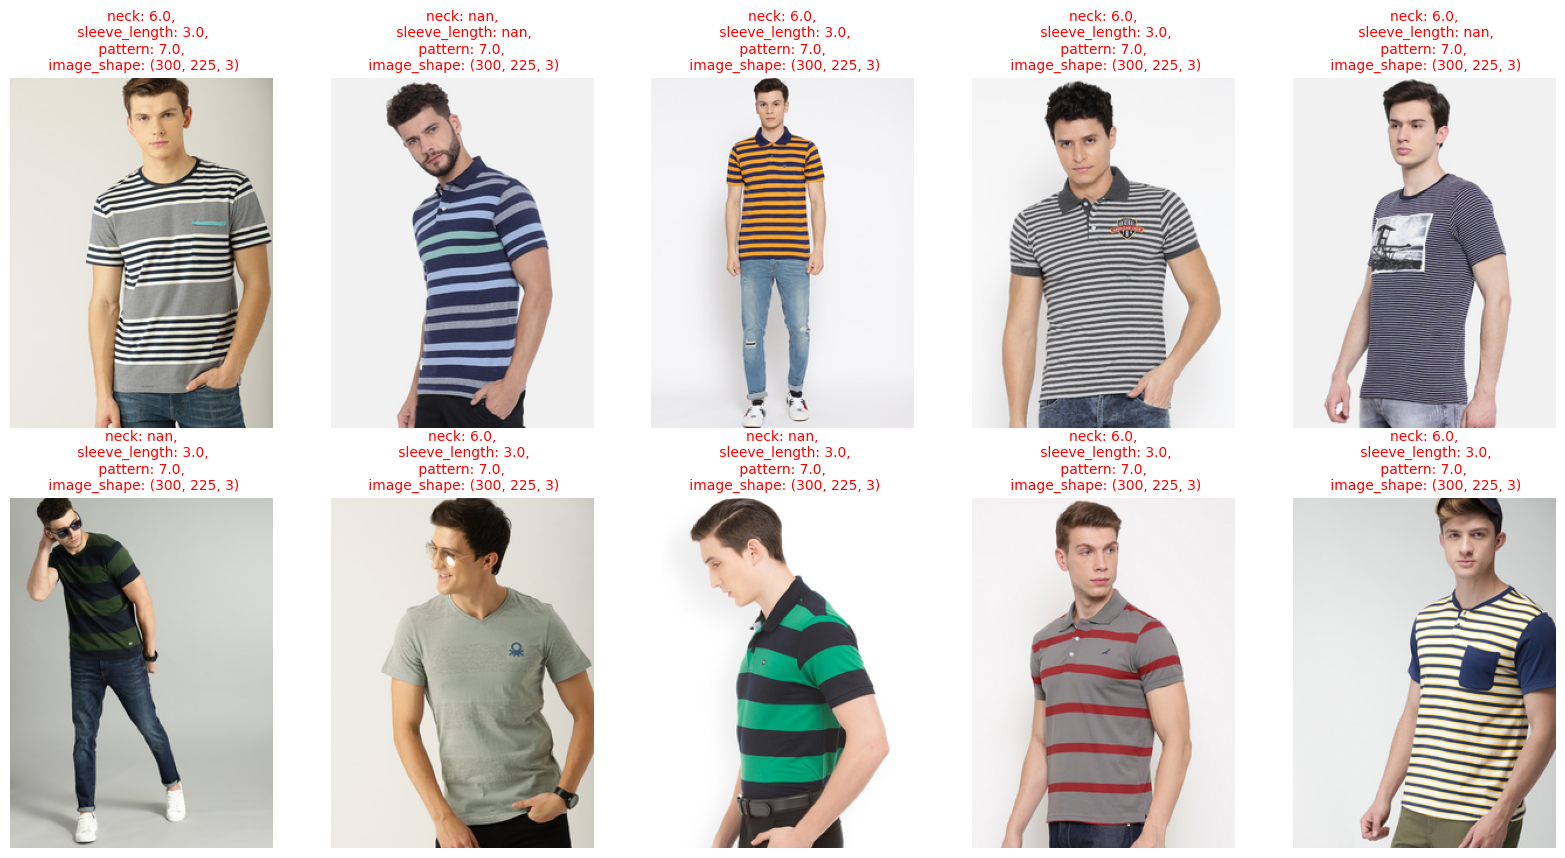

In [15]:
def get_filenames_with_attribute(attribute_df, attribute_name, class_value):
    """
    Extracts filenames from an attribute dataframe where a particular attribute is equal to some class.

    Args:
      attribute_df: A Pandas DataFrame containing the attribute data.
      attribute_name: The name of the attribute to filter on.
      class_value: The class value to filter for.

    Returns:
      A list of filenames where the specified attribute has the specified class value.
    """

    filtered_df = attribute_df[attribute_df[attribute_name] == class_value]
    filenames = filtered_df['filename'].tolist()
    return filenames

# select the attribute name and value
# filenames_with_attribute = get_filenames_with_attribute(attributes_df, 'neck', 1)
# filenames_with_attribute = get_filenames_with_attribute(attributes_df, 'sleeve_length', 2)
filenames_with_attribute = get_filenames_with_attribute(attributes_df, 'pattern', 7)

display_10_random_images(filenames_with_attribute, image_directory)

Based on this class information, we can remove the duplicates

In [16]:
# @title compare_duplicates
def compare_duplicates(duplicates_df):
    """
    This function takes a DataFrame containing duplicate rows and returns a cleaned DataFrame
    with the most relevant values for each duplicate group.
    """
    final_df = pd.DataFrame(columns=duplicates_df.columns)
    unknown_class_id = {
        'neck' : 6,
        'sleeve_length' : 3,
        'pattern' : 9
    }

    # Group the duplicates by filename
    for filename, group_df in duplicates_df.groupby('filename'):

        # Initialize a dictionary to store the final values for each attribute
        final_values = {
          'filename': filename,
          'neck': None,
          'sleeve_length': None,
          'pattern': None
        }

        # Iterate through each row in the group
        for _, row in group_df.iterrows():
            for attribute, value in row.items():
                if attribute == 'filename':
                    continue
                # If the current value is not NaN and not unknown_class_id, update the final value
                if (not pd.isna(value)) and (value != unknown_class_id[attribute]):
                    final_values[attribute] = value

                # If current value is NaN, only update if attribute value is NaN, or attribute value is unknown_class_id
                elif pd.isna(value) and (pd.isna(final_values[attribute]) or final_values[attribute] == unknown_class_id[attribute]):
                    final_values[attribute] = value


                elif value == unknown_class_id[attribute] and final_values[attribute] is None:
                    final_values[attribute] = value

        final_df = pd.concat([final_df, pd.DataFrame([final_values])], ignore_index=False)

    return final_df

cleaned_df = compare_duplicates(duplicates_df)
print(cleaned_df.info(),"\n\n")
cleaned_df

<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, 0 to 0
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   filename       13 non-null     object 
 1   neck           11 non-null     float64
 2   sleeve_length  9 non-null      float64
 3   pattern        7 non-null      float64
dtypes: float64(3), object(1)
memory usage: 520.0+ bytes
None 




,filename,neck,sleeve_length,pattern
0,11500972213413-HERENOW-Men-Navy-Blue-Solid-Hen...,0.0,0.0,NaN
0,11518854922727-Peter-England-Men-Blue-Solid-Ma...,2.0,3.0,NaN
0,11519985443093-na-6291519985442963-1.jpg,6.0,2.0,9.0
0,11520422272285-Tommy-Hilfiger-Men-Grey-Solid-P...,2.0,NaN,NaN
0,11520494542273-na-4501520494542174-5.jpg,0.0,0.0,9.0
0,11521455242291-IndigoGrey-Melange-Sleeveless-H...,1.0,2.0,NaN
0,184ee860-cb0c-43e9-a59f-b087d9517e971535628417...,1.0,NaN,9.0
0,22c51074-4ad3-4c3a-aa2f-9753849ebde51530877671...,6.0,2.0,NaN
0,3d2204b9-8db8-41bc-9e6e-7dcbd0e5bfd81527921368...,NaN,1.0,9.0
0,50c01c83-1c2e-4152-ab27-c5c3b914ba3d1526967669...,NaN,NaN,9.0


In [17]:
# @title remove_duplicates
# remove the filenames present in cleaned_df from attributes_df and then concatenate with cleaned_df
attributes_df = pd.concat([attributes_df[~attributes_df['filename'].isin(cleaned_df['filename'])], cleaned_df])

# reset indexes
attributes_df = attributes_df.reset_index(drop=True)

attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   filename       1782 non-null   object 
 1   neck           1413 non-null   float64
 2   sleeve_length  1420 non-null   float64
 3   pattern        1424 non-null   float64
dtypes: float64(3), object(1)
memory usage: 55.8+ KB


We have cleaned the output labels, removed duplicates. Now let us see the distribution of different classes.

In [18]:
attributes_df.isnull().sum()

filename           0
neck             369
sleeve_length    362
pattern          358
dtype: int64

Missing values still remain, which we will remove in next section.

## 3. Univariate Analysis

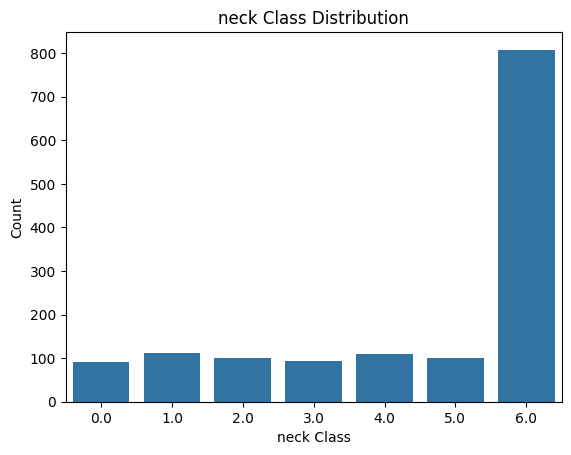

neck
6.0    808
1.0    111
4.0    110
5.0    100
2.0    100
3.0     93
0.0     91
Name: count, dtype: int64
Total:  1413


In [19]:
# @title `neck` class distribution histogram
sns.countplot(x=attributes_df['neck'])
plt.title('neck Class Distribution')
plt.xlabel('neck Class')
plt.ylabel('Count')
plt.show()

count_neck = attributes_df['neck'].value_counts()
print(count_neck)
print(f"Total:  {count_neck.sum()}")

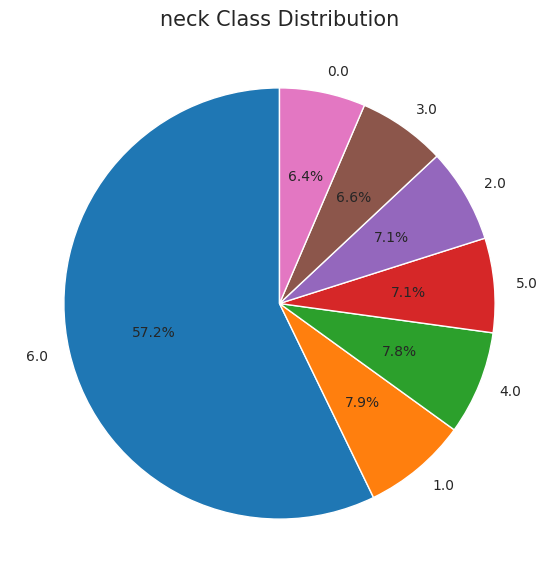

In [20]:
# @title `neck` class distribution percentages

plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")
plt.pie(count_neck, labels=count_neck.index, autopct="%1.1f%%", startangle=90)
plt.title("neck Class Distribution", fontsize=15)
plt.show()

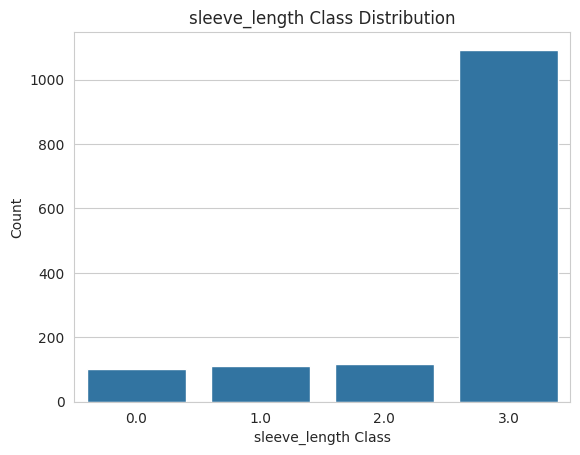

sleeve_length
3.0    1093
2.0     117
1.0     109
0.0     101
Name: count, dtype: int64
Total:  1420


In [21]:
# @title `sleeve_length` class distribution

sns.countplot(x=attributes_df['sleeve_length'])
plt.title('sleeve_length Class Distribution')
plt.xlabel('sleeve_length Class')
plt.ylabel('Count')
plt.show()

count_sleeve_length = attributes_df['sleeve_length'].value_counts()
print(count_sleeve_length)
print(f"Total:  {count_sleeve_length.sum()}")

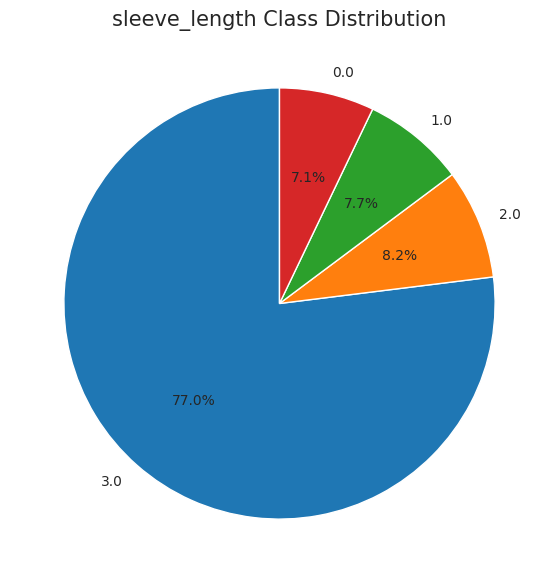

In [22]:
# @title `sleeve_length` class distribution percentages

plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")
plt.pie(count_sleeve_length, labels=count_sleeve_length.index, autopct="%1.1f%%", startangle=90)
plt.title("sleeve_length Class Distribution", fontsize=15)
plt.show()

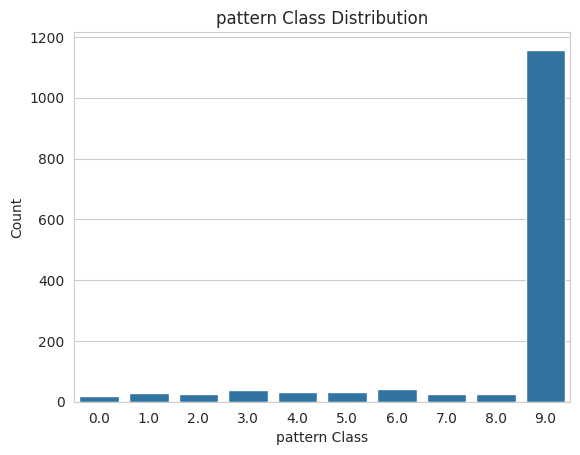

pattern
9.0    1158
6.0      43
3.0      38
4.0      33
5.0      31
1.0      28
8.0      26
7.0      24
2.0      24
0.0      19
Name: count, dtype: int64
Total:  1424


In [23]:
# @title `pattern` class distribution

sns.countplot(x=attributes_df['pattern'])
plt.title('pattern Class Distribution')
plt.xlabel('pattern Class')
plt.ylabel('Count')
plt.show()

count_pattern = attributes_df['pattern'].value_counts()
print(count_pattern)
print(f"Total:  {count_pattern.sum()}")

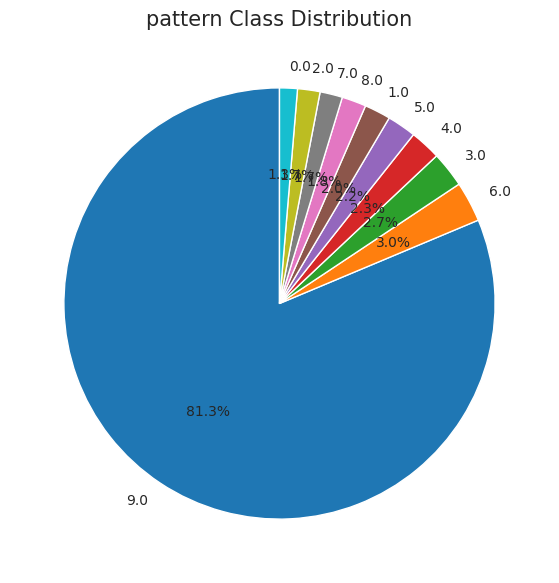

In [24]:
# @title `pattern` class distribution percentages

plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")
plt.pie(count_pattern, labels=count_pattern.index, autopct="%1.1f%%", startangle=90)
plt.title("pattern Class Distribution", fontsize=15)
plt.show()

We still have missing values, and the unknown class dominates in all 3 labels.

## Assigning classes based on keywords in the filenames

In [25]:
attribute_classes = {
    'neck': {
        0: {'henley'},
        1: {'hood'},
        2: {'mandarin'},
        3: {'polo'},
        4: {'round'},
        5: {'v-neck'},
    },
    'sleeve_length': {
        0: {'full-sleev', 'long-sleev', 'fullsleev', 'longsleev'},
        1: {'half-sleev', 'short-sleev', 'halfsleev', 'shortsleev'},
        2: {'sleeveless'},
    },
    'pattern': {
        0: {'camouflage'},
        1: {'checked'},
        3: {'graphic'},
        5: {'self-design'},
        6: {'solid'},
        7: {'striped'},
        8: {'text', 'typography'},
    }
}

In [26]:
def most_likely_class_keyword(attribute_classes, filename, label_col, class_id, unknown_class_id):
    """
    Finds the most likely class for a given filename based on the keywords in attribute_classes.

    Args:
      attribute_classes: A dictionary mapping attribute names to a dictionary of class values and keywords.
      filename: The filename to classify.
      label_col: The column name of the label column in the attributes_df.
      class_id: The ID of the class for the filenames.
      unknown_class_id: The ID of the class to use for undetermined classes.

    Returns:
      The most likely class for the filename.
    """

    if not (pd.isna(class_id) or class_id == unknown_class_id):
        return class_id, False

    # Either class_id is NaN or it belongs to unknown class
    most_likely_class = None
    need_for_update = False

    # Loop through each class value and keywords in attribute_classes
    for class_value, keywords in attribute_classes[label_col].items():
        for keyword in keywords:

            # If keyword found in filename
            if keyword in filename.lower():
                most_likely_class = class_value
                need_for_update = True
                # print(f"{label_col} : {filename} : {keyword} : {class_value}")
                break
        if most_likely_class is not None:
            break
    else:
        most_likely_class = class_id
    return most_likely_class, need_for_update


# # Testing the function
# most_likely_class = most_likely_class_keyword(attribute_classes, attributes_df['filename'][4], 'sleeve_length', attributes_df['sleeve_length'][4], 6)
# most_likely_class

In [27]:
def replace_nan_with_class_id(attributes_df, attribute_classes):
    """
    Replaces NaN or "All mixed" values in the specified attribute columns of the
    attributes_df with the most likely class based on the keywords in attribute_classes.

    Args:
      attributes_df: A Pandas DataFrame containing the attribute data.
      attribute_classes: A dictionary mapping attribute names to a dictionary of class values and keywords.

    Returns:
      A new Pandas DataFrame with NaN or "All mixed" values replaced with the most likely class.
    """

    updated_df = attributes_df.copy()

    for idx, row in updated_df.iterrows():
        filename = row['filename']
        neck_class = row['neck']
        sleeve_length_class = row['sleeve_length']
        pattern_class = row['pattern']

        most_likely_class, update_neck = most_likely_class_keyword(attribute_classes, filename, 'neck', neck_class, 6)
        if update_neck:
            # Update the attribute value in the new DataFrame
            updated_df.loc[idx, 'neck'] = most_likely_class

        most_likely_class, update_sleeve_length = most_likely_class_keyword(attribute_classes, filename, 'sleeve_length', sleeve_length_class, 3)
        if update_sleeve_length:
            # Update the attribute value in the new DataFrame
            updated_df.loc[idx, 'sleeve_length'] = most_likely_class

        most_likely_class, update_pattern = most_likely_class_keyword(attribute_classes, filename, 'pattern', pattern_class, 9)
        if update_pattern:
            # Update the attribute value in the new DataFrame
            updated_df.loc[idx, 'pattern'] = most_likely_class

    return updated_df

# Update the attributes_df with the new function
updated_df = replace_nan_with_class_id(attributes_df, attribute_classes)

# Save the updated DataFrame to a new CSV file
# updated_df.to_csv('updated_df.csv')
attributes_df = updated_df.copy()

In [28]:
# Class value count for neck
count_neck = attributes_df['neck'].value_counts()
print(count_neck)
print(f"Total:  {count_neck.sum()}")
print(f"NaN: {attributes_df['neck'].isnull().sum()}")

neck
4.0    443
6.0    390
3.0    257
1.0    136
5.0    133
0.0    120
2.0    116
Name: count, dtype: int64
Total:  1595
NaN: 187


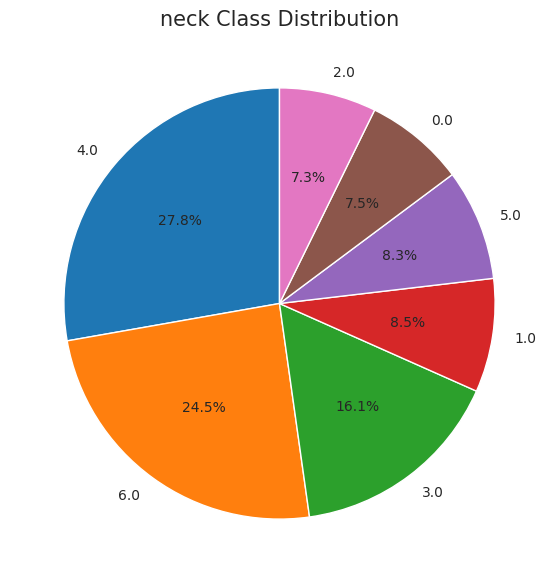

In [29]:
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")
plt.pie(count_neck, labels=count_neck.index, autopct="%1.1f%%", startangle=90)
plt.title("neck Class Distribution", fontsize=15)
plt.show()

In [30]:
# Class value count for sleeve_length
count_sleeve_length = attributes_df['sleeve_length'].value_counts()
print(count_sleeve_length)
print(f"Total:  {count_sleeve_length.sum()}")
print(f"NaN: {attributes_df['sleeve_length'].isnull().sum()}")

sleeve_length
3.0    1055
1.0     133
2.0     128
0.0     124
Name: count, dtype: int64
Total:  1440
NaN: 342


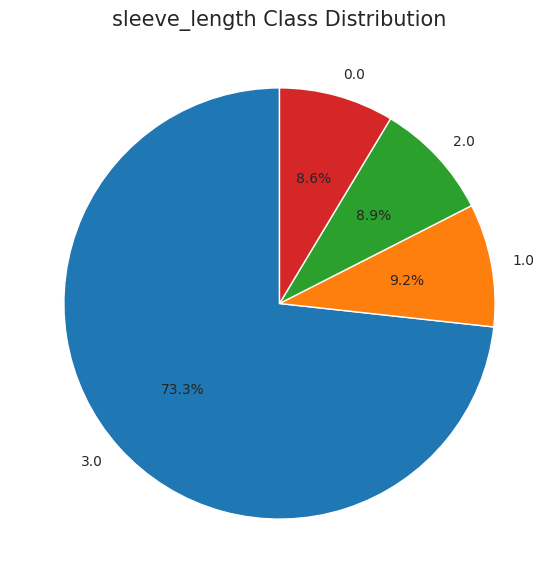

In [31]:
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")
plt.pie(count_sleeve_length, labels=count_sleeve_length.index, autopct="%1.1f%%", startangle=90)
plt.title("sleeve_length Class Distribution", fontsize=15)
plt.show()

In [32]:
count_pattern = attributes_df['pattern'].value_counts()
print(count_pattern)
print(f"Total:  {count_pattern.sum()}")
print(f"NaN: {attributes_df['pattern'].isnull().sum()}")

pattern
9.0    806
6.0    354
7.0    132
5.0     68
3.0     42
4.0     33
1.0     33
8.0     28
2.0     24
0.0     21
Name: count, dtype: int64
Total:  1541
NaN: 241


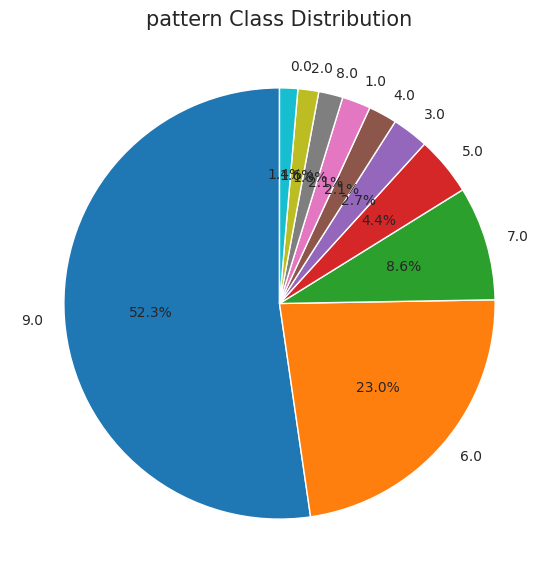

In [33]:
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")
plt.pie(count_pattern, labels=count_pattern.index, autopct="%1.1f%%", startangle=90)
plt.title("pattern Class Distribution", fontsize=15)
plt.show()

## Handling Missing Values

In [34]:
attributes_df.isnull().sum()

filename           0
neck             187
sleeve_length    342
pattern          241
dtype: int64

In [35]:
print(f" Total rows in attributes: {attributes_df.shape[0]}")
df_remove = attributes_df.dropna(axis = 0)
print(f" Total rows after dropping missing value: {df_remove.shape[0]}")

print(f"Loss of data: {round((attributes_df.shape[0] - df_remove.shape[0])*100/attributes_df.shape[0],2)}%")

 Total rows in attributes: 1782
 Total rows after dropping missing value: 1118
Loss of data: 37.26%


We simply cannot drop the rows with the missing values because this would result in a loss of approximately 37% of data.

There are many imputation methods for imputing missing values. There is usually a pattern which these attributes follow when they come together. As the values are categorical in nature, choosing a method which can infer the missing values, from other columns can be benficial.

Due to this I am picking imputation using k-Nearest Neighbors method.

KNNImputer is better in this case, than IterativeImputer.

KNNImputer uses the k-nearest neighbors algorithm to impute missing values. This means that it looks at the k most similar data points to the data point with the missing value and uses the values of those data points to impute the missing value. This method is particularly well-suited for categorical data, as it can take into account the relationships between different categories.

IterativeImputer, on the other hand, uses a regression model to impute missing values. This means that it fits a regression model to the non-missing data and then uses the model to predict the missing values. This method is not as well-suited for categorical data, as it does not take into account the relationships between different categories.

Therefore, KNNImputer is the better choice for imputing missing values in this case.

In [36]:
attributes_df_copy = attributes_df.copy()

# Performing imputation using kNN method
from sklearn.impute import KNNImputer

cols_with_missing = ['neck', 'sleeve_length', 'pattern']

knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
imputed_values = knn_imputer.fit_transform(attributes_df[cols_with_missing])
imputed_values = np.round(imputed_values).astype(int)

attributes_df[cols_with_missing] = imputed_values
attributes_df.isnull().sum()

filename         0
neck             0
sleeve_length    0
pattern          0
dtype: int64

In [37]:
attributes_df.head(10)

,filename,neck,sleeve_length,pattern
0,cdc8cd2a-0938-4970-a3b5-f5ed9595222c1527925869...,3,3,4
1,11469770662809-Metersbonwe-Navy-T-shirt-485146...,5,3,9
2,f7ad67ab-eeb1-4449-8f63-7b580d2797e71532342804...,6,0,9
3,11516770810185-Splash-Men-Tshirts-767151677081...,6,3,9
4,11505295751483-FOREVER-21-Men-White-Self-Desig...,1,3,5
5,11461827372049-US-Polo-Assn-Navy-T-shirt-20714...,5,3,9
6,90044561-8959-460a-a650-49a6772237931537435887...,3,3,7
7,11520918258005-Vudu-Mens-Casual-Grey-Color-T-S...,6,3,9
8,11519017746785-Difference-of-Opinion-Khaki-Pri...,6,3,9
9,94b6ab4b-50c9-4d10-847a-4b4482531d651529052514...,4,3,8


# Data Preprocessing Pipeline

In [38]:
# @title Preprocess Images
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(img_path, target_size):
    """
    Preprocess image to ensure a certain size,
    normalize pixel values, and convert to numpy array.

    Args:
      img_path: Path to the image file.
      target_size: Target size for the image. w x h

    Returns:
      Preprocessed image as a numpy array.
    """
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    return img


image_file = os.path.join(image_directory, image_file_names[0])
preprocessed_image = preprocess_image(image_file, (224, 224))
preprocessed_image

array([[[[0.9764706 , 0.9764706 , 0.9764706 ],
         [0.9764706 , 0.9764706 , 0.9764706 ],
         [0.9764706 , 0.9764706 , 0.9764706 ],
         ...,
         [0.92156863, 0.9254902 , 0.93333334],
         [0.92156863, 0.9254902 , 0.93333334],
         [0.92156863, 0.9254902 , 0.93333334]],

        [[0.9764706 , 0.9764706 , 0.9764706 ],
         [0.9764706 , 0.9764706 , 0.9764706 ],
         [0.9764706 , 0.9764706 , 0.9764706 ],
         ...,
         [0.92156863, 0.9254902 , 0.93333334],
         [0.92156863, 0.9254902 , 0.93333334],
         [0.92156863, 0.9254902 , 0.93333334]],

        [[0.9764706 , 0.9764706 , 0.9764706 ],
         [0.9764706 , 0.9764706 , 0.9764706 ],
         [0.9764706 , 0.9764706 , 0.9764706 ],
         ...,
         [0.92156863, 0.9254902 , 0.93333334],
         [0.92156863, 0.9254902 , 0.93333334],
         [0.92156863, 0.9254902 , 0.93333334]],

        ...,

        [[0.9490196 , 0.9529412 , 0.9607843 ],
         [0.9490196 , 0.9529412 , 0.9607843 ]

# Model Definition and Compilation

For the task I am selecting ResNet50, with its output layers modified.

In [39]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [41]:
# @title ResNet50 Model Compilation
class MultiOutputDataGenerator(Sequence):
    """
    Custom data generator for multi-output classification.
    """

    def __init__(self, df, image_dir, batch_size, input_size, shuffle=True, augment=False):
        self.df = df
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        """
        Returns the number of batches per epoch.
        """
        return int(np.floor(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        """
        Updates indices after each epoch.
        """
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        """
        Returns a batch of data.
        """
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[indices]

        X, y_neck, y_sleeve_length, y_pattern = self.__data_generation(batch_df)

        return X, {'neck_output': y_neck, 'sleeve_length_output': y_sleeve_length, 'pattern_output': y_pattern}

    def __data_generation(self, batch_df):
        """
        Generates data for a batch of images.
        """
        X = np.empty((self.batch_size, *self.input_size))
        y_neck = np.empty((self.batch_size, num_classes_neck), dtype=int)
        y_sleeve_length = np.empty((self.batch_size, num_classes_sleeve_length), dtype=int)
        y_pattern = np.empty((self.batch_size, num_classes_pattern), dtype=int)

        for i, (index, row) in enumerate(batch_df.iterrows()):
            img_path = os.path.join(self.image_dir, row['filename'])
            img = load_img(img_path, target_size=self.input_size[:2])
            img = img_to_array(img) / 255.0

            X[i,] = img
            y_neck[i,] = tf.keras.utils.to_categorical(row['neck'], num_classes_neck)
            y_sleeve_length[i,] = tf.keras.utils.to_categorical(row['sleeve_length'], num_classes_sleeve_length)
            y_pattern[i,] = tf.keras.utils.to_categorical(row['pattern'], num_classes_pattern)

        return X, y_neck, y_sleeve_length, y_pattern

# Parameters
input_shape = (224, 224, 3)
batch_size = 32
epochs = 20

# Number of classes for each attribute
# I unitially thought of training with the known classes
# Then I thought, if a garment belongs to two classes, it should
# be flagged an unknown, so that it appears in search of both classes
num_classes_neck = 7
num_classes_sleeve_length = 4
num_classes_pattern = 10

# Split into training and validation sets
train_df = attributes_df.sample(frac=0.8, random_state=42)
valid_df = attributes_df.drop(train_df.index)

# Create data generators
train_generator = MultiOutputDataGenerator(train_df, image_directory, batch_size, input_shape, shuffle=True, augment=True)
valid_generator = MultiOutputDataGenerator(valid_df, image_directory, batch_size, input_shape, shuffle=False, augment=False)

# Load the ResNet50 model with pre-trained ImageNet weights, exclude top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers for each attribute
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

output_neck = Dense(num_classes_neck, activation='softmax', name='neck_output')(x)
output_sleeve_length = Dense(num_classes_sleeve_length, activation='softmax', name='sleeve_length_output')(x)
output_pattern = Dense(num_classes_pattern, activation='softmax', name='pattern_output')(x)

model = Model(inputs=base_model.input, outputs=[output_neck, output_sleeve_length, output_pattern])

# Compile the model
model.compile(
    optimizer=Adam(),
    loss={'neck_output': 'categorical_crossentropy',
          'sleeve_length_output': 'categorical_crossentropy',
          'pattern_output': 'categorical_crossentropy'},
    metrics={'neck_output': 'accuracy',
             'sleeve_length_output': 'accuracy',
             'pattern_output': 'accuracy'}
)

model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [42]:
# @title Training the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator
)

Epoch 1/20
44/44 [==============================] - 414s 9s/step - loss: 14.6552 - neck_output_loss: 5.7039 - sleeve_length_output_loss: 3.1709 - pattern_output_loss: 5.7804 - neck_output_accuracy: 0.1719 - sleeve_length_output_accuracy: 0.6491 - pattern_output_accuracy: 0.3303 - val_loss: 4.6964 - val_neck_output_loss: 1.9329 - val_sleeve_length_output_loss: 0.9084 - val_pattern_output_loss: 1.8551 - val_neck_output_accuracy: 0.2727 - val_sleeve_length_output_accuracy: 0.7244 - val_pattern_output_accuracy: 0.4375
Epoch 2/20
44/44 [==============================] - 402s 9s/step - loss: 4.9631 - neck_output_loss: 1.9592 - sleeve_length_output_loss: 1.0392 - pattern_output_loss: 1.9647 - neck_output_accuracy: 0.2386 - sleeve_length_output_accuracy: 0.7216 - pattern_output_accuracy: 0.4744 - val_loss: 4.5901 - val_neck_output_loss: 1.8616 - val_sleeve_length_output_loss: 0.9195 - val_pattern_output_loss: 1.8090 - val_neck_output_accuracy: 0.2727 - val_sleeve_length_output_accuracy: 0.7244

In [43]:
model.save('trained_resnet50.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
# generate the exact version of requirements
!pip freeze > requirements.txt

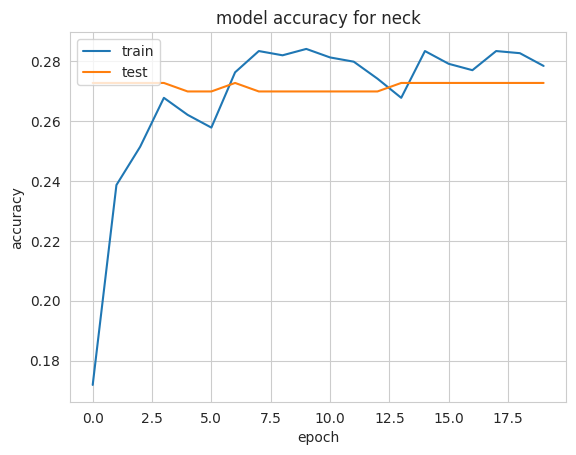

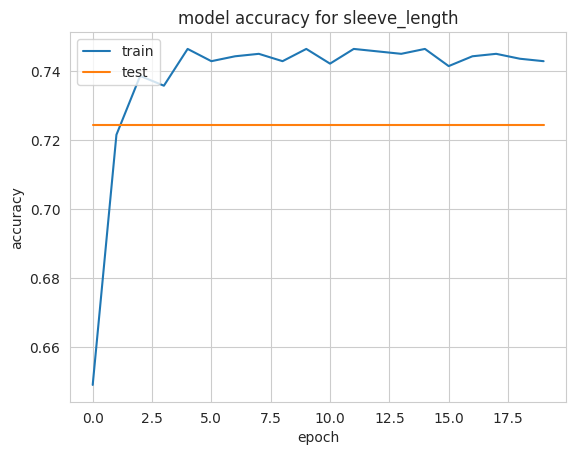

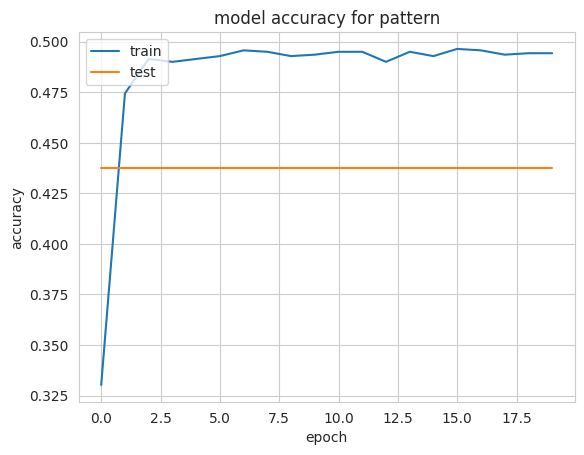

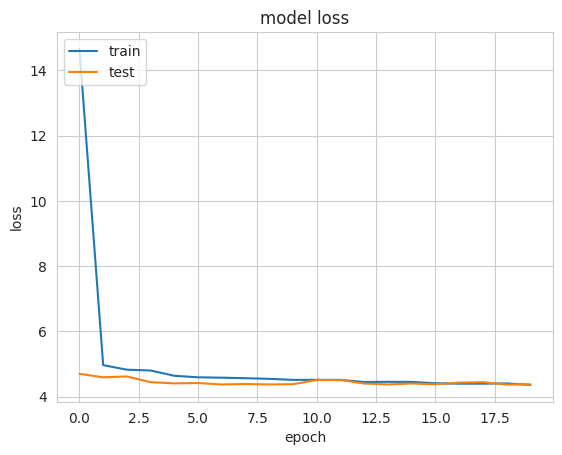

In [48]:
# @title plot accuracy and loss
plt.plot(history.history['neck_output_accuracy'])
plt.plot(history.history['val_neck_output_accuracy'])
plt.title('model accuracy for neck')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['sleeve_length_output_accuracy'])
plt.plot(history.history['val_sleeve_length_output_accuracy'])
plt.title('model accuracy for sleeve_length')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['pattern_output_accuracy'])
plt.plot(history.history['val_pattern_output_accuracy'])
plt.title('model accuracy for pattern')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# Inference Script

In [51]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array


def preprocess_image(img_path, target_size):
    """
    Preprocess image to ensure a certain size,
    normalize pixel values, and convert to numpy array.

    Args:
      img_path: Path to the image file.
      target_size: Target size for the image. w x h

    Returns:
      Preprocessed image as a numpy array.
    """
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    return img


def predict_attributes(image_paths, model_path):
    """
    Function to get attribute predictions for a batch of images

    Args:
      image_paths: List of image paths
      model_path: Path to the trained model

    Returns:
      A DataFrame containing the predicted attributes for each image
    """
    predictions = []

    # load the pre-trained model for inference
    model = tf.keras.models.load_model(model_path)

    for img_path in image_paths:
        img = preprocess_image(img_path, (224, 224))
        preds = model.predict(img)

        neck_pred = np.argmax(preds[0], axis=1)[0]
        sleeve_length_pred = np.argmax(preds[1], axis=1)[0]
        pattern_pred = np.argmax(preds[2], axis=1)[0]

        predictions.append({
            'filename': img_path,
            'neck': neck_pred,
            'sleeve_length': sleeve_length_pred,
            'pattern': pattern_pred
        })

    return pd.DataFrame(predictions)


if __name__ == '__main__':
  """
  Example usage: Inference script

  Inputs:
  image_directory = './test_images'  # replace with your image directory path
  model_path = './trained_resnet50.h5'  # replace above if needed

  Outputs:
  Output.csv: csv file containing the predicted attributes for each image.

  """

  image_directory = './test_images'     # replace with your image directory path
  model_path = './trained_resnet50.h5'  # replace with model path

  # generate paths to images
  image_paths = [os.path.join(image_directory, fname) for fname in os.listdir(image_directory) if fname.endswith('.jpg')]

  predicted_attributes = predict_attributes(image_paths, model_path)
  print(predicted_attributes)

  # Save the updated DataFrame to a new CSV file
  predicted_attributes.to_csv('Output.csv')


1/1 [==============================] - 0s 217ms/step
              filename  neck  sleeve_length  pattern
0  ./test_images/2.jpg     4              3        9
1  ./test_images/3.jpg     4              3        9
2  ./test_images/1.jpg     4              3        9
